# Data Analisys

Here you can find all necessery data preparation and analisys

In [50]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np

## Data normalisation

First of all extract usefull information from raw data

In [51]:
def normalize_json(data):
    authors = (data.get("authors") or {}).get("author", [])
    if isinstance(authors, str):
        authors = [authors]
    elif not isinstance(authors, list):
        authors = []
    return {
        "load_date": data.get("load-date"),
        "links": [{"ref": link["@ref"], "href": link["@href"]} for link in data.get("link", [])],
        "identifier": data.get("dc:identifier"),
        "url": data.get("prism:url"),
        "title": data.get("dc:title"),
        "creator": data.get("dc:creator"),
        "publication_name": data.get("prism:publicationName"),
        "volume": data.get("prism:volume"),
        "cover_date": data.get("prism:coverDate"),
        "starting_page": data.get("prism:startingPage"),
        "doi": data.get("prism:doi"),
        "openaccess": data.get("openaccess"),
        "pii": data.get("pii"),
        "authors": [author["$"] if isinstance(author, dict) and "$" in author else str(author) for author in authors]
    }

In [52]:
with open('out/raw_data.json', 'r') as file:
    data = json.load(file)

print(len(data))

10000


In [58]:
normalized_json_list = [normalize_json(item) for item in data]
with open('out/norm_data.json', 'w') as file:
    json.dump(normalized_json_list, file, indent=4)
normalized_json_list[0]

{'load_date': '2025-01-03T00:00:00.000Z',
 'links': [{'ref': 'self',
   'href': 'https://api.elsevier.com/content/article/pii/S0893395224002680'},
  {'ref': 'scidir',
   'href': 'https://www.sciencedirect.com/science/article/pii/S0893395224002680?dgcid=api_sd_search-api-endpoint'}],
 'identifier': 'DOI:10.1016/j.modpat.2024.100688',
 'url': 'https://api.elsevier.com/content/article/pii/S0893395224002680',
 'title': 'Introduction to Artificial Intelligence and Machine Learning in Pathology and Medicine: Generative and Nongenerative Artificial Intelligence Basics',
 'creator': 'Hooman H. Rashidi',
 'publication_name': 'Modern Pathology',
 'volume': '38',
 'cover_date': '2025-04-30',
 'starting_page': '100688',
 'doi': '10.1016/j.modpat.2024.100688',
 'openaccess': True,
 'pii': 'S0893395224002680',
 'authors': ['Hooman H. Rashidi', 'Joshua Pantanowitz', 'Liron Pantanowitz']}

In [54]:
df_journals = pd.DataFrame(normalized_json_list)

journal_counts = Counter(df_journals["publication_name"].dropna())
top_journals = journal_counts.most_common(10)
journals, counts = zip(*top_journals)

grouped = df_journals.groupby("publication_name")[["cover_date"]].apply(
    lambda x: x["cover_date"].str[:4].value_counts().sort_index()
).unstack(fill_value=0)
grouped_top = grouped.loc[list(journals)].fillna(0)

## Data visualisation

Now we can visualise our data and study it

On the following graph we can clearly see exponential groth of number of papers. By our predictions, at the end of the 2025 there will be more than 6000 papers released

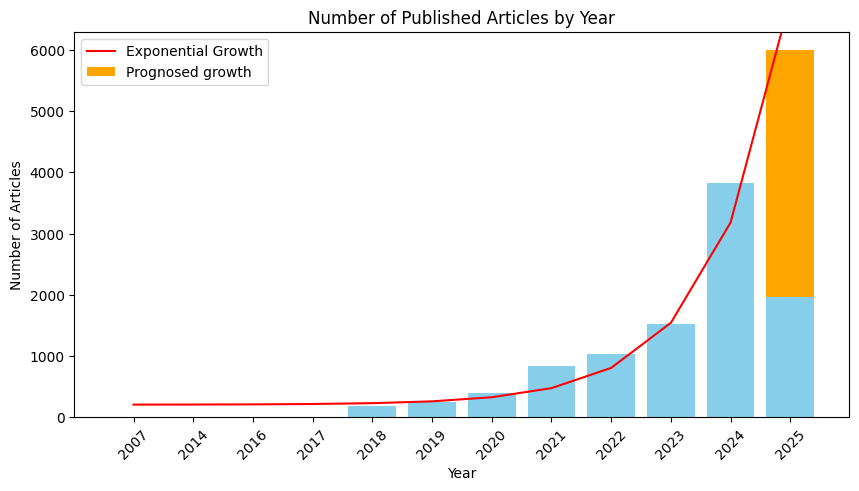

In [55]:
years = [item["cover_date"][:4] for item in normalized_json_list if item["cover_date"]]
year_counts = Counter(years)

df = pd.DataFrame(year_counts.items(), columns=["Year", "Number of Articles"])
df = df.sort_values("Year")

plt.figure(figsize=(10, 5))
plt.bar(df["Year"], df["Number of Articles"], color="skyblue")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("Number of Published Articles by Year")
plt.xticks(rotation=45)
plt.ylim((0, 6300))
x = np.arange(len(df["Year"]))
y = np.exp(x*.8) + 200
plt.plot(df["Year"], y, color="red", label="Exponential Growth")
last_bin_index = len(df) - 1
current_height = df["Number of Articles"].iloc[last_bin_index]
plt.bar(df["Year"].iloc[last_bin_index], 6000 - current_height, bottom=current_height, color="orange", label="Prognosed growth")
plt.legend()
# plt.savefig("articles_by_year.png")

### Measurement Journal

The "Measurement" journal is one of the top 10 most popular journals in the dataset. It has shown significant growth in the number of publications over the years, particularly in 2024 and 2025. Below is a summary of its publication trends:

- **2023**: 6 publications
- **2024**: 8 publications
- **2025**: 163 publications

This exponential increase highlights the growing interest in the journal, particularly in recent years.

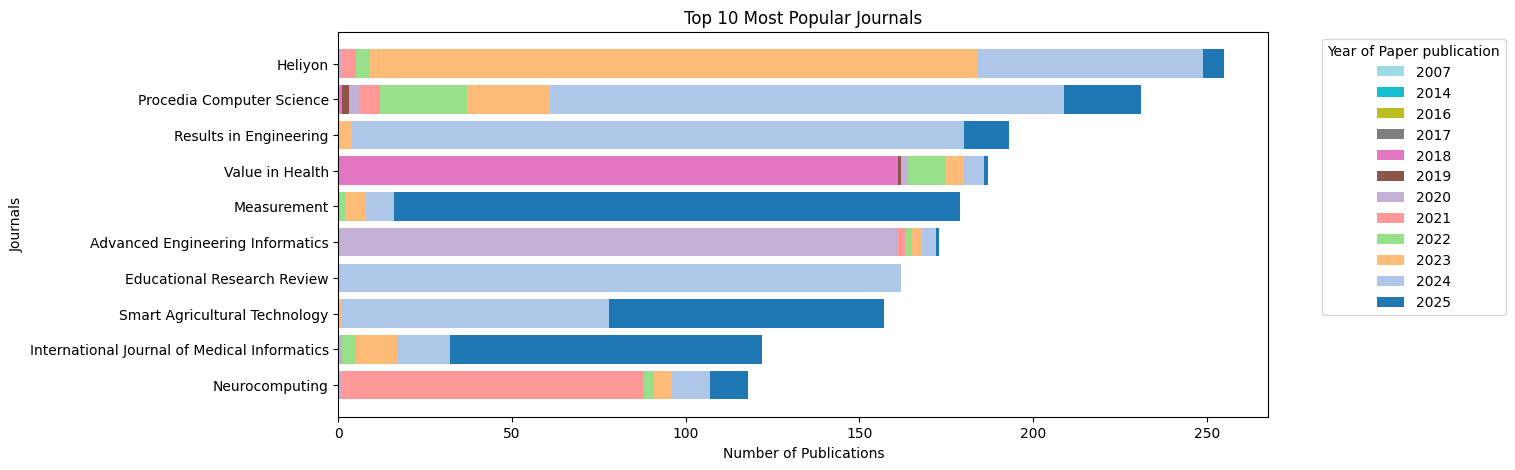

In [56]:
plt.figure(figsize=(12, 5))
colors = plt.cm.tab20(np.linspace(0, 1, len(grouped_top.columns))[::-1])
for i, year in enumerate(grouped_top.columns):
    plt.barh(journals, grouped_top[year], color=colors[i], label=year, left=grouped_top.iloc[:, :i].sum(axis=1) if i > 0 else None)
plt.legend(title="Year of Paper publication", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Number of Publications")
plt.ylabel("Journals")
plt.title("Top 10 Most Popular Journals")
plt.gca().invert_yaxis()
# plt.savefig("top_journals.png")